In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
train_dir = 'Dataset/train'
validation_dir = 'Dataset/test'

BATCH_SIZE = 16
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2651 files belonging to 5 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 660 files belonging to 5 classes.


In [19]:
class_names = train_dataset.class_names
print(class_names)

['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']


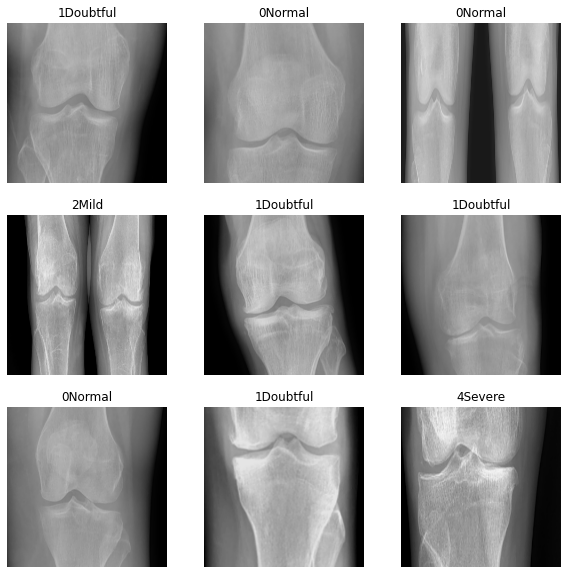

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 160, 160, 3)
(16,)


In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
normalization_layer = layers.Rescaling(1./255)

In [26]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.88561124


In [28]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)       

In [31]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
166/166 [==============================] - 48s 286ms/step - loss: 1.4805 - accuracy: 0.3508 - val_loss: 1.4456 - val_accuracy: 0.3652
Epoch 2/10
166/166 [==============================] - 48s 291ms/step - loss: 1.3115 - accuracy: 0.4364 - val_loss: 1.3296 - val_accuracy: 0.4152
Epoch 3/10
166/166 [==============================] - 45s 268ms/step - loss: 1.0910 - accuracy: 0.5530 - val_loss: 1.0823 - val_accuracy: 0.5303
Epoch 4/10
166/166 [==============================] - 47s 286ms/step - loss: 0.8566 - accuracy: 0.6609 - val_loss: 0.8471 - val_accuracy: 0.6364
Epoch 5/10
166/166 [==============================] - 42s 255ms/step - loss: 0.6223 - accuracy: 0.7699 - val_loss: 0.7518 - val_accuracy: 0.7121
Epoch 6/10
166/166 [==============================] - 41s 246ms/step - loss: 0.4154 - accuracy: 0.8465 - val_loss: 0.6481 - val_accuracy: 0.7848
Epoch 7/10
166/166 [==============================] - 41s 250ms/step - loss: 0.2468 - accuracy: 0.9238 - val_loss: 0.6295 - val_ac

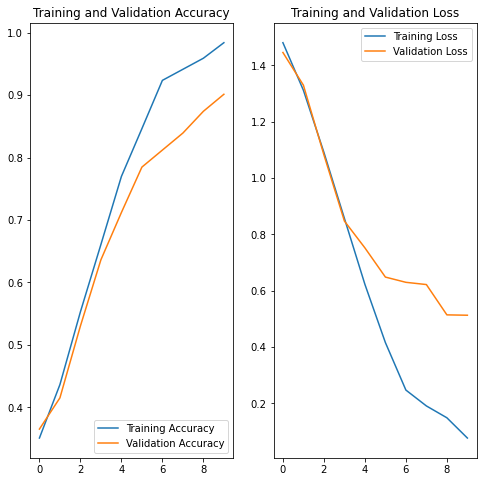

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
image_path = r"Dataset\test\1Doubtful\1DoubtfulG1 (6).png"

img = tf.keras.utils.load_img(
    image_path, target_size=(IMG_SIZE[0], IMG_SIZE[1])
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 1Doubtful with a 96.10 percent confidence.
